In [1]:
%matplotlib inline
import pandas as pd, datetime as dt
import collections
import numpy as np
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import glob, os

### Input CO2 T-A and fuel type

In [2]:
TA = 120  # g/km, the type-approval for this vehicle

fuel_type = str('diesel')

In [3]:
if fuel_type == 'diesel':
    NOx_lim = 80 # mg/km
    print(NOx_lim)
elif fuel_type == 'gasoline':
    NOx_lim = 60 # mg/km
    print(NOx_lim)
else:
    print('enter valid fuel type')

80


## NOx vs CO2

In [14]:
files_lab = glob.glob('*C.xls')                                                   # read all VELA2 files
dic_lab = {}                                                                     # empty dictionary lab tests
                                                                    
i = 1
for each in files_lab:
    
    %time df = pd.read_excel(each, sheetname=1, header=0)                          # read the proper sheets within each file
  
    CO2 = df['c_CO2_Dil_g_vec\n[grams]']
    CO2_sum = CO2.sum()
    NOx = df['c_NOx_Dil_g_vec\n[grams]']
    NOx_sum = NOx.sum()
    
    v = df['DACtrl_ActualSpeed\n[kph]']            #group speed by intervals
    t_s = len(df.index)                                                #  time(s)
    t_h = t_s/3600                                                                    # time (hours)
    v_mean = v.mean()                                                  # speed means
    d = v_mean * t_h #b.reset_index(drop=True) * d.reset_index(drop=True)                # distance means
    
    CO2km = CO2_sum/d                                                    # CO2 per km 
    #CO2pct = CO2km*100/CO2_TA                                            # emissions as % of type approval (98 g/km)
    NOxkm = NOx_sum/d                                                    # NOx / km
    
    key = each.split('al_')[1].split('.x')[0]                             # shortening the titles of the files
    
    key = str(i) + "." + str(key)                                        # numbering the files
    dic_lab[key] = [CO2km , NOxkm, d, t_s]                                         # save means in the dictionary
    i = i+1

Wall time: 422 ms
Wall time: 630 ms
Wall time: 738 ms
Wall time: 546 ms
Wall time: 583 ms
Wall time: 638 ms
Wall time: 675 ms
Wall time: 422 ms
Wall time: 640 ms
Wall time: 426 ms
Wall time: 424 ms
Wall time: 647 ms
Wall time: 423 ms
Wall time: 972 ms
Wall time: 756 ms
Wall time: 643 ms
Wall time: 421 ms
Wall time: 633 ms


In [5]:
files_road = glob.glob('*[0-9].xlsx')                                         # read all EMROAD files
dic_road = {}                                                            # empty dictionary road test

i = 1
for each in files_road:
    
    %time df = pd.read_excel(each, sheetname='TEST REPORT', header=6)

    df.rename(columns=lambda x: x.strip().replace(" ", "_"), inplace=True)   # convert the headers to read them: ' ' for '_'
    df.rename(columns=lambda x: x.strip().replace(".", "_"), inplace=True)   # convert the headers to read them: '.' for '_'
    
    
    CO2_COMP = df.COMPLETE_TEST['CO2'][1]      # g/km
    #CO2_COMP = CO2_COMP_*100/CO2_TA             # %
    CO2_URB = df.URBAN['CO2'][1]               # g/km
    #CO2_URB = CO2_URB_*100/CO2_TA               # %
    CO2_RUR = df.RURAL['CO2'][1]               # g/km
    #CO2_RUR = CO2_RUR_*100/CO2_TA               # %
    CO2_MOT = df.MOTORW_['CO2'][1]             # g/km
    #CO2_MOT = CO2_MOT_*100/CO2_TA               # %
    #CO2 = [CO2_COMP,CO2_URB,CO2_RUR,CO2_MOT]
    
    NOx_COMP = df.COMPLETE_TEST['NOx'][1]
    NOx_URB = df.URBAN['NOx'][1]
    NOx_RUR = df.RURAL['NOx'][1]
    NOx_MOT = df.MOTORW_['NOx'][1]

    #NOx = [NOx_COMP,NOx_URB,NOx_RUR,NOx_MOT]
    
    key = each.split('035_')[1].split('_E')[0]
    each = str(i) + "_" + str(each)
    dic_road[each] = [CO2_COMP,NOx_COMP,CO2_URB,NOx_URB,CO2_RUR,NOx_RUR,CO2_MOT,NOx_MOT]     # save means in the dictionary
    i = i+1

Wall time: 17.2 s
Wall time: 16.2 s
Wall time: 18.1 s
Wall time: 18.5 s
Wall time: 18.8 s
Wall time: 22.8 s
Wall time: 23.4 s
Wall time: 16.6 s
Wall time: 15.7 s


In [15]:
lab = pd.DataFrame()                                                          
lab = lab.from_dict(dic_lab, orient='index')                                  # convert dic to dataframe
lab['ind2'] = ['04','08','07','04','06','11','01','05','11',
               '01','01','12','02','10','12','09','03','12']                                       # proper order
lab.columns = ['CO2_lab','NOx_lab','d','t_s','ind2']                          # headers
lab['NOx_lab'] = lab['NOx_lab']*1000                                          # change unit to mg/km

In [16]:
lab = lab.sort_values('ind2')

lab['test'] = ['N_CD_23','N_CD_23','N_CD_23','N_CD_10',
               'N_CD_30','N_CD_4W_23','N_CD_4W_23','N_HT_23',
               'N_HT_4W_23','W_CD_4W_23','W_HT_4W_23','W_CD_4W_30',
               'W_CD_4W_10','W_CD_0','W_CD_0','W_CD-7','W_CD-7','W_CD-7']

lab.columns = ['CO2_lab','NOx_lab','d','t_s','ind2','test']
lab

,CO2_lab,NOx_lab,d,t_s,ind2,test
7.NEDC_COLD_FWDsync_23C,151.067827,77.884642,10.862547,1181,01,N_CD_23
10.NEDC_COLD_FWDsync_23C,150.713390,69.807769,10.771351,1181,01,N_CD_23
11.NEDC_COLD_FWDsync_23C,151.297805,53.329779,10.844199,1181,01,N_CD_23
13.NEDC_COLD_FWDsync_10C,164.173048,137.960354,10.830128,1181,02,N_CD_10
17.NEDC_COLD_FWD-sync_30C,146.052706,70.364887,10.847713,1181,03,N_CD_30
1.NEDC_COLD_4WD_23C,163.744091,119.482403,10.898082,1181,04,N_CD_4W_23
4.NEDC_COLD_4WD_23C,168.048346,101.616424,10.908547,1180,04,N_CD_4W_23
8.NEDC_HOT_FWDsync_23C,143.619332,87.233923,10.820741,1181,05,N_HT_23
5.NEDC_HOT_4WD_23C,155.630973,150.914271,10.845672,1181,06,N_HT_4W_23
3.WLTP_COLD_4WD_23c,175.949167,222.199272,23.266507,1801,07,W_CD_4W_23


In [17]:
name = lab.groupby(lab.ind2).mean()#.reset_index()#drop = True)
name['test'] = ['N_CD_23','N_CD_10','N_CD_30','N_CD_4W_23','N_HT_23','N_HT_4W_23',
               'W_CD_4W_23','W_HT_4W_23','W_CD_4W_30','W_CD_4W_10','W_CD_0','W_CD-7']
                
name.columns = ['CO2_lab','NOx_lab','d','t_s','test']

name

,CO2_lab,NOx_lab,d,t_s,test
ind2,,,,,
01,151.026341,67.007396,10.826032,1181.0,N_CD_23
02,164.173048,137.960354,10.830128,1181.0,N_CD_10
03,146.052706,70.364887,10.847713,1181.0,N_CD_30
04,165.896218,110.549414,10.903315,1180.5,N_CD_4W_23
05,143.619332,87.233923,10.820741,1181.0,N_HT_23
06,155.630973,150.914271,10.845672,1181.0,N_HT_4W_23
07,175.949167,222.199272,23.266507,1801.0,W_CD_4W_23
08,177.646725,310.062020,23.290534,1801.0,W_HT_4W_23
09,164.460484,151.739148,23.283650,1801.0,W_CD_4W_30


In [61]:
road = pd.DataFrame()                               # convert dic to dataframe
road = road.from_dict(dic_road, orient='index')             # proper order
road['ALPH'] = ['a','b','c','d','e','f','g','h','i']              # indexing by letters
road.columns = ['CO2_COMP','NOx_COMP','CO2_URB','NOx_URB','CO2_RUR','NOx_RUR','CO2_MOT','NOx_MOT','ALPH']  # headers

road['NOx_COMP']=road['NOx_COMP']*1000                  # change unit to mg/km
road['NOx_URB']=road['NOx_URB']*1000                    # change unit to mg/km
road['NOx_RUR']=road['NOx_RUR']*1000                    # change unit to mg/km
road['NOx_MOT']=road['NOx_MOT']*1000                    # change unit to mg/km

road = road.sort_values('ALPH')
road

,CO2_COMP,NOx_COMP,CO2_URB,NOx_URB,CO2_RUR,NOx_RUR,CO2_MOT,NOx_MOT,ALPH
1_VW035_ESP_2016_07_12_EMROAD_Test1.xlsx,164.666526,342.319902,217.179848,340.391917,123.343782,363.794052,138.131211,323.176840,a
2_VW035_ESP_2016_07_12_EMROAD_Test2.xlsx,167.556831,393.958026,222.111856,391.472224,126.396417,416.737002,140.761859,372.904319,b
3_VW035_LAB_2016_07_08_EMROAD_Test1.xlsx,172.857546,229.935369,226.929049,266.073652,128.751939,222.406167,145.823918,185.198384,c
4_VW035_LAB_2016_07_11_EMROAD_Test2.xlsx,174.434373,326.130348,224.631733,358.248561,141.574919,394.086133,148.003715,225.895925,d
5_VW035_LAB_2016_07_11_EMROAD_Test3.xlsx,186.213976,383.900158,236.336151,384.423773,130.048084,301.495885,179.367534,454.862010,e
6_VW035_MIL_2016_07_25_EMROAD_Test1.xlsx,144.468396,180.549843,207.144166,309.561857,108.849504,168.475775,130.449561,131.296796,f
7_VW035_MIL_2016_07_25_EMROAD_Test2.xlsx,165.479311,256.163115,263.651706,420.454325,120.775462,226.677689,148.411360,211.005757,g
8_VW035_SAC_2016_07_26_EMROAD_Test1.xlsx,214.720299,413.385012,221.713892,425.348298,120.818203,252.755478,NaN,NaN,h
9_VW035_SAC_2016_07_26_EMROAD_Test2.xlsx,209.277634,453.159971,228.410289,509.212456,108.356865,157.494793,NaN,NaN,i


In [62]:
### Reshape index ###
r = road
r.index = r.index.str[8:11]
r

,CO2_COMP,NOx_COMP,CO2_URB,NOx_URB,CO2_RUR,NOx_RUR,CO2_MOT,NOx_MOT,ALPH
ESP,164.666526,342.319902,217.179848,340.391917,123.343782,363.794052,138.131211,323.176840,a
ESP,167.556831,393.958026,222.111856,391.472224,126.396417,416.737002,140.761859,372.904319,b
LAB,172.857546,229.935369,226.929049,266.073652,128.751939,222.406167,145.823918,185.198384,c
LAB,174.434373,326.130348,224.631733,358.248561,141.574919,394.086133,148.003715,225.895925,d
LAB,186.213976,383.900158,236.336151,384.423773,130.048084,301.495885,179.367534,454.862010,e
MIL,144.468396,180.549843,207.144166,309.561857,108.849504,168.475775,130.449561,131.296796,f
MIL,165.479311,256.163115,263.651706,420.454325,120.775462,226.677689,148.411360,211.005757,g
SAC,214.720299,413.385012,221.713892,425.348298,120.818203,252.755478,NaN,NaN,h
SAC,209.277634,453.159971,228.410289,509.212456,108.356865,157.494793,NaN,NaN,i


In [67]:
### Group by index and calculate means ###
r_avg = r.groupby(r.index).mean()#.reset_index()#drop = True)
#r_avg['test'] = ['ESP','LAB','MIL','SAC']
                
r_avg.columns = ['CO2_COMP','NOx_COMP','CO2_URB','NOx_URB','CO2_RUR','NOx_RUR','CO2_MOT','NOx_MOT']

r_avg[['CO2_COMP','NOx_COMP']]


,CO2_COMP,NOx_COMP
ESP,166.111679,368.138964
LAB,177.835298,313.321958
MIL,154.973854,218.356479
SAC,211.998966,433.272491


## Plot all tests

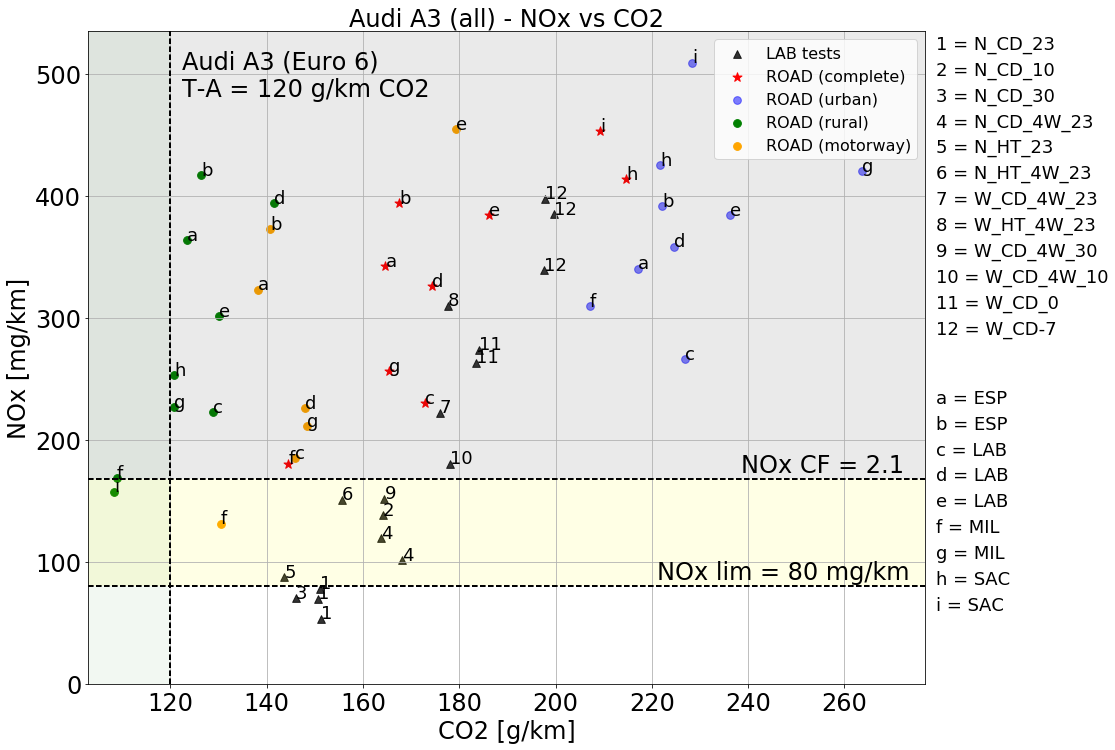

In [18]:
ax = lab.plot.scatter('CO2_lab', 'NOx_lab',marker='^', alpha=.8 ,s = 60, c = 'black', 
                      figsize = (15,12), grid ='on')
#plt.legend(lab.index, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#for ea in road.index:
road.plot.scatter('CO2_COMP','NOx_COMP', ax=ax, marker='*', s = 90, c = 'red', grid = 'on')
road.plot.scatter('CO2_URB','NOx_URB', ax=ax, s = 60, alpha=.5, c = 'blue', grid = 'on')
road.plot.scatter('CO2_RUR','NOx_RUR', ax=ax, s = 60, c = 'green', grid = 'on')
road.plot.scatter('CO2_MOT','NOx_MOT', ax=ax, s = 60, c = 'orange', grid = 'on')

legend = ('LAB tests','ROAD (complete)','ROAD (urban)','ROAD (rural)','ROAD (motorway)')
plt.legend(legend, fontsize = 16, loc = 'best')


fontsize = 24
plt.ylabel('NOx [mg/km]', fontsize = fontsize)
plt.xlabel('CO2 [g/km]', fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.title('Audi A3 (all) - NOx vs CO2', fontsize = fontsize)

lim_inf_CO2 = min(lab.CO2_lab.min(),road.CO2_COMP.min(), road.CO2_URB.min(),
                 road.CO2_RUR.min(),road.CO2_MOT.min()) -0.05*min(lab.CO2_lab.min(),
                road.CO2_COMP.min(), road.CO2_URB.min(), road.CO2_RUR.min(),road.CO2_MOT.min())
lim_sup_CO2 = max(lab.CO2_lab.max(),road.CO2_COMP.max(), road.CO2_URB.max(),
                 road.CO2_RUR.max(),road.CO2_MOT.max()) +0.05*max(lab.CO2_lab.max(),
                road.CO2_COMP.max(), road.CO2_URB.max(), road.CO2_RUR.max(),road.CO2_MOT.max())
lim_inf_NOx = min(lab.NOx_lab.min(),road.NOx_COMP.min(), road.NOx_URB.min(),
                 road.NOx_RUR.min(),road.NOx_MOT.min()) -0.05*min(lab.NOx_lab.min(),
                road.NOx_COMP.min(), road.NOx_URB.min(), road.NOx_RUR.min(),road.NOx_MOT.min())
lim_sup_NOx = max(lab.NOx_lab.max(),road.NOx_COMP.max(), road.NOx_URB.max(),
                 road.NOx_RUR.max(),road.NOx_MOT.max()) +0.05*max(lab.NOx_lab.max(),
                road.NOx_COMP.max(), road.NOx_URB.max(), road.NOx_RUR.max(),road.NOx_MOT.max())

###
#lim_inf_CO2 = 95
###

plt.axis([lim_inf_CO2,lim_sup_CO2,0,lim_sup_NOx])                         

if len(name)<10:
    for i, txt in enumerate(lab.ind2):
        ax.annotate(txt, (lab.CO2_lab.iat[i],lab.NOx_lab.iat[i]), ha = 'left', fontsize = 18, clip_on=True)
else:
    for i, txt in enumerate(lab.ind2):
        if i<[i for i,x in enumerate(lab.ind2) if x == '10'][0]:
            ax.annotate(txt.split('0')[1], (lab.CO2_lab.iat[i],lab.NOx_lab.iat[i]), ha = 'left', fontsize = 18)#, rotation = 30)
        else:
            ax.annotate(txt, (lab.CO2_lab.iat[i],lab.NOx_lab.iat[i]), ha = 'left', fontsize = 18, clip_on=True)#, rotation = 30)
        
for i, txt in enumerate(road.ALPH):
    ax.annotate(txt + '', (road.CO2_COMP.iat[i],road.NOx_COMP.iat[i]), ha = 'left', fontsize = 18, clip_on=True)
for i, txt in enumerate(road.ALPH):
    ax.annotate(txt + '', (road.CO2_URB.iat[i],road.NOx_URB.iat[i]), ha = 'left', fontsize = 18, clip_on=True)
for i, txt in enumerate(road.ALPH):
    ax.annotate(txt + '', (road.CO2_RUR.iat[i],road.NOx_RUR.iat[i]), ha = 'left', fontsize = 18, clip_on=True)
for i, txt in enumerate(road.ALPH):
    ax.annotate(txt + '', (road.CO2_MOT.iat[i],road.NOx_MOT.iat[i]), ha = 'left', fontsize = 18, clip_on=True)
    
i = 1
for each in name.test:
    plt.gcf().text(0.91, 0.89 - 0.03*i, str(i) + ' = ' +  each, fontsize=18)  
    i = i+1

i = 0
for each in road.index:
    plt.gcf().text(0.91, 0.45 - 0.03*i, road.ALPH[i] + ' = ' + each.split('035_')[1].split('_2016')[0] , fontsize=18)
    i = i+1
    
if TA>lim_inf_CO2:
    ax.annotate('Audi A3 (Euro 6) \nT-A = ' + str(TA) + ' g/km CO2',
                (TA+0.02*TA, lim_sup_NOx-0.1*lim_sup_NOx), textcoords='data', fontsize=24, clip_on=True)
else:
    ax.annotate('Audi A3 (Euro 6) \nT-A = ' + str(TA) + ' g/km CO2',
                (lim_inf_CO2+0.02*lim_inf_CO2, lim_sup_NOx-0.1*lim_sup_NOx), textcoords='data', fontsize=24, clip_on=True)
    
ax.annotate('NOx CF = 2.1',(lim_sup_CO2 - 0.22*(lim_sup_CO2-lim_inf_CO2), NOx_lim*2.1 + 0.01*lim_sup_NOx),
            textcoords='data', fontsize=24, clip_on=True)
ax.annotate('NOx lim = ' + str(NOx_lim) + ' mg/km',(lim_sup_CO2 - 0.32*(lim_sup_CO2-lim_inf_CO2), NOx_lim + 0.01*lim_sup_NOx),
            textcoords='data', fontsize=24, clip_on=True)

plt.axvline(x=TA, color='k', linestyle='--', linewidth=2 )
plt.axhline(y=NOx_lim, color='k', linestyle='--', linewidth=2 )
plt.axhline(y=NOx_lim*2.1, color='k', linestyle='--', linewidth=2 )
plt.axhspan(NOx_lim, NOx_lim*2.1, facecolor='yellow', alpha=0.1)
plt.axhspan(NOx_lim*2.1, lim_sup_NOx, facecolor='0.2', alpha=0.1)
plt.axvspan(lim_inf_CO2, TA, facecolor='green', alpha=0.05)

## Plot avg of repeated tests

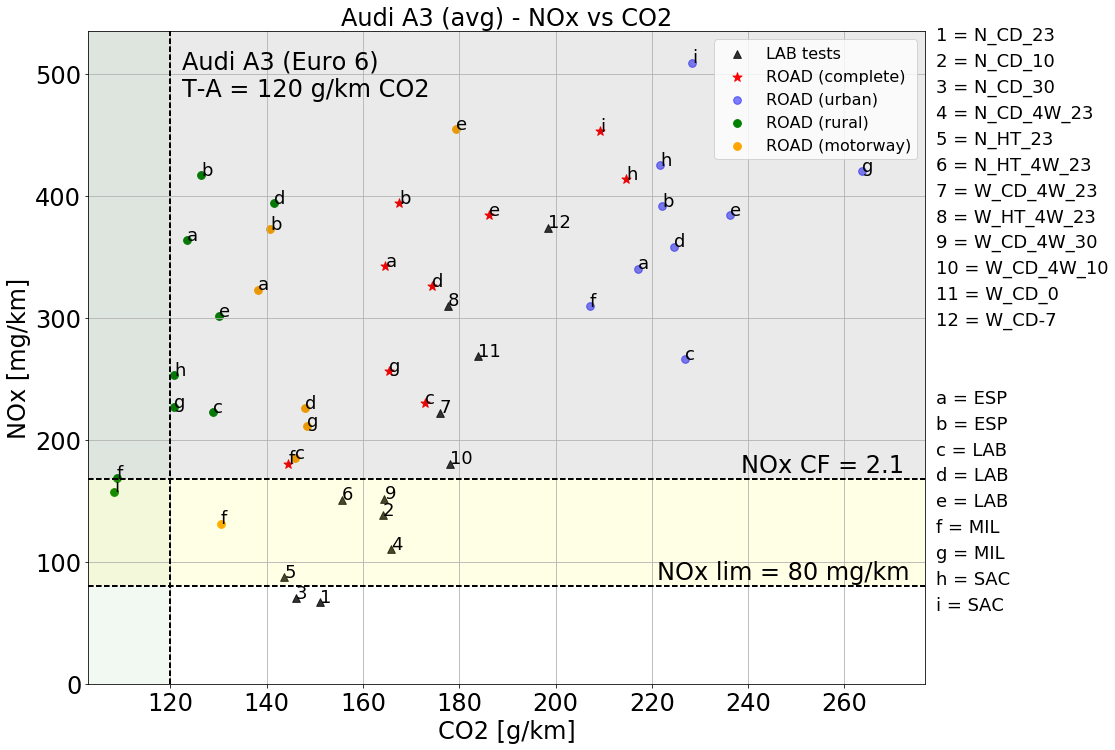

In [19]:
ax = name.plot.scatter('CO2_lab', 'NOx_lab',marker='^', alpha=.8 ,s = 60, c = 'black', 
                      figsize = (15,12), grid ='on')
#plt.legend(lab.index, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#for ea in road.index:
road.plot.scatter('CO2_COMP','NOx_COMP', ax=ax, marker='*', s = 90, c = 'red', grid = 'on')
road.plot.scatter('CO2_URB','NOx_URB', ax=ax, s = 60, alpha=.5, c = 'blue', grid = 'on')
road.plot.scatter('CO2_RUR','NOx_RUR', ax=ax, s = 60, c = 'green', grid = 'on')
road.plot.scatter('CO2_MOT','NOx_MOT', ax=ax, s = 60, c = 'orange', grid = 'on')

legend = ('LAB tests','ROAD (complete)','ROAD (urban)','ROAD (rural)','ROAD (motorway)')
plt.legend(legend, fontsize = 16, loc = 'best')

fontsize = 24
plt.ylabel('NOx [mg/km]', fontsize = fontsize)
plt.xlabel('CO2 [g/km]', fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.title('Audi A3 (avg) - NOx vs CO2', fontsize = fontsize)

lim_inf_CO2 = min(name.CO2_lab.min(),road.CO2_COMP.min(), road.CO2_URB.min(),
                 road.CO2_RUR.min(),road.CO2_MOT.min()) -0.05*min(name.CO2_lab.min(),
                road.CO2_COMP.min(), road.CO2_URB.min(), road.CO2_RUR.min(),road.CO2_MOT.min())
lim_sup_CO2 = max(name.CO2_lab.max(),road.CO2_COMP.max(), road.CO2_URB.max(),
                 road.CO2_RUR.max(),road.CO2_MOT.max()) +0.05*max(name.CO2_lab.max(),
                road.CO2_COMP.max(), road.CO2_URB.max(), road.CO2_RUR.max(),road.CO2_MOT.max())
lim_inf_NOx = min(name.NOx_lab.min(),road.NOx_COMP.min(), road.NOx_URB.min(),
                 road.NOx_RUR.min(),road.NOx_MOT.min()) -0.05*min(name.NOx_lab.min(),
                road.NOx_COMP.min(), road.NOx_URB.min(), road.NOx_RUR.min(),road.NOx_MOT.min())
lim_sup_NOx = max(name.NOx_lab.max(),road.NOx_COMP.max(), road.NOx_URB.max(),
                 road.NOx_RUR.max(),road.NOx_MOT.max()) +0.05*max(name.NOx_lab.max(),
                road.NOx_COMP.max(), road.NOx_URB.max(), road.NOx_RUR.max(),road.NOx_MOT.max())

###
#lim_inf_CO2 = 95
###

plt.axis([lim_inf_CO2,lim_sup_CO2,0,lim_sup_NOx])                             


for i, txt in enumerate(name.test):
    ax.annotate(i+1, (name.CO2_lab.iat[i],name.NOx_lab.iat[i]), ha = 'left', fontsize = 18, clip_on=True) # change txt to i+1
        
for i, txt in enumerate(road.ALPH):
    ax.annotate(txt + '', (road.CO2_COMP.iat[i],road.NOx_COMP.iat[i]), ha = 'left', fontsize = 18, clip_on=True)
for i, txt in enumerate(road.ALPH):
    ax.annotate(txt + '', (road.CO2_URB.iat[i],road.NOx_URB.iat[i]), ha = 'left', fontsize = 18, clip_on=True)
for i, txt in enumerate(road.ALPH):
    ax.annotate(txt + '', (road.CO2_RUR.iat[i],road.NOx_RUR.iat[i]), ha = 'left', fontsize = 18, clip_on=True)
for i, txt in enumerate(road.ALPH):
    ax.annotate(txt + '', (road.CO2_MOT.iat[i],road.NOx_MOT.iat[i]), ha = 'left', fontsize = 18, clip_on=True)
    
i = 1
for each in name.test:
    plt.gcf().text(0.91, 0.9 - 0.03*i, str(i) + ' = ' +  each, fontsize=18)  
    i = i+1

i = 0
for each in road.index:
    plt.gcf().text(0.91, 0.45 - 0.03*i, road.ALPH[i] + ' = ' + each.split('035_')[1].split('_2016')[0] , fontsize=18)
    i = i+1
    
ax.annotate('Audi A3 (Euro 6) \nT-A = ' + str(TA) + ' g/km CO2',(TA+0.02*TA, lim_sup_NOx-0.1*lim_sup_NOx),
            textcoords='data', fontsize=24, clip_on=True)
ax.annotate('NOx CF = 2.1',(lim_sup_CO2 - 0.22*(lim_sup_CO2-lim_inf_CO2), NOx_lim*2.1 + 0.01*lim_sup_NOx),
            textcoords='data', fontsize=24, clip_on=True)
ax.annotate('NOx lim = ' + str(NOx_lim) + ' mg/km',(lim_sup_CO2 - 0.32*(lim_sup_CO2-lim_inf_CO2), NOx_lim + 0.01*lim_sup_NOx),
            textcoords='data', fontsize=24, clip_on=True)

plt.axvline(x=TA, color='k', linestyle='--', linewidth=2 )
plt.axhline(y=NOx_lim, color='k', linestyle='--', linewidth=2 )
plt.axhline(y=NOx_lim*2.1, color='k', linestyle='--', linewidth=2 )
plt.axhspan(NOx_lim, NOx_lim*2.1, facecolor='yellow', alpha=0.1)
plt.axhspan(NOx_lim*2.1, lim_sup_NOx, facecolor='0.2', alpha=0.1)
plt.axvspan(lim_inf_CO2, TA, facecolor='green', alpha=0.05)